In [3]:
# Developer docs
# https://www.tensorflow.org/tutorials/keras/classification
# https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Importing modules
from os import listdir, system
import pandas as pd
import numpy as np
import sys
import time
import pandas as pd

import cv2 as cv2
import imutils
import imageio
import pickle
from IPython.display import clear_output, display, HTML


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
from skimage.io import imread
from skimage import measure
from skimage.measure import regionprops
from skimage.transform import resize
from scipy import ndimage


# Downloading dataset from: http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/
# You can comment this after running once.

### CHARS74K DATASET FOR TRAINING
# !wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
# !tar -xvzf ./EnglishImg.tgz && rm -rf EnglishImg.tgz
# !git clone https://github.com/captcha-breakers/dataset-training-uppercase-1.git

# CAPTCHA DATA: DOWNLOAD ANYONE & APPROPRIATELY CONFIGURE THE PATH
# !git clone https://github.com/captcha-breakers/dataset-simple-uppercase.git
# !git clone https://github.com/rdmpage/solving-captchas-code-examples.git
# !git clone https://github.com/captcha-breakers/dataset-pycaptcha-uppercase.git

Cloning into 'dataset-training-uppercase-1'...
remote: Enumerating objects: 23974, done.
remote: Counting objects: 100% (23974/23974), done.
remote: Compressing objects: 100% (23974/23974), done.
remote: Total 23974 (delta 0), reused 23974 (delta 0), pack-reused 0
Receiving objects: 100% (23974/23974), 16.02 MiB | 20.71 MiB/s, done.


In [4]:
# Setting up folders
base_dir = "./dataset-training-uppercase-1/data/"
folders = listdir(base_dir)
folders.sort()
folders = folders[:36]
print(folders)

# Setting image_size
image_size = (20, 20)

['Sample1', 'Sample10', 'Sample11', 'Sample12', 'Sample13', 'Sample14', 'Sample15', 'Sample16', 'Sample17', 'Sample18', 'Sample19', 'Sample2', 'Sample20', 'Sample21', 'Sample22', 'Sample23', 'Sample24', 'Sample25', 'Sample26', 'Sample27', 'Sample28', 'Sample29', 'Sample3', 'Sample30', 'Sample31', 'Sample32', 'Sample33', 'Sample34', 'Sample35', 'Sample36', 'Sample4', 'Sample5', 'Sample6', 'Sample7', 'Sample8', 'Sample9']


In [5]:
# Collecting images from folders
data = []
total_images = 0
for i in folders:
    all_images = listdir(base_dir+i)[:1000]
    total_images+=len(all_images)
    currentlabel = int(i[6:])-1

    for name in all_images:
        image = cv2.imread(base_dir+i+"/"+name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, image_size)

        # Filtering
        # image = cv2.GaussianBlur(image,(5,5),0)
        # image = cv2.Laplacian(image,cv2.CV_64F)
        # image = cv2.GaussianBlur(image,(5,5),0)
        # kernel = np.ones((3, 3), np.uint8)
        # image = cv2.filter2D(image,-1,kernel)
        
        data.append((image/255, currentlabel))
    
    if int(i[6:])<=10:
      print("Images for", currentlabel,":",  len(all_images))
    else:
      print("Images for", chr(65-11+currentlabel+1),":",  len(all_images))
print("Total images: ", total_images)

Images for 0 : 1000
Images for 9 : 1000
Images for A : 1000
Images for B : 1000
Images for C : 1000
Images for D : 1000
Images for E : 1000
Images for F : 1000
Images for G : 1000
Images for H : 1000
Images for I : 1000
Images for 1 : 1000
Images for J : 1000
Images for K : 1000
Images for L : 1000
Images for M : 1000
Images for N : 1000
Images for O : 1000
Images for P : 1000
Images for Q : 1000
Images for R : 1000
Images for S : 1000
Images for 2 : 1000
Images for T : 1000
Images for U : 1000
Images for V : 1000
Images for W : 1000
Images for X : 1000
Images for Y : 1000
Images for Z : 1000
Images for 3 : 1000
Images for 4 : 1000
Images for 5 : 1000
Images for 6 : 1000
Images for 7 : 1000
Images for 8 : 1000
Total images:  36000


In [6]:
# Shuffling data & making train/test
np.random.shuffle(data)
n = len(data)
p = int(80*n/100)

train_images = []
train_labels = []
test_images = []
test_labels = []
for i in range(n):
    if i<p:
        train_images.append(data[i][0])
        train_labels.append(data[i][1])
    else:
        test_images.append(data[i][0])
        test_labels.append(data[i][1])

1
5
9
27
27
15
21
0
30
23


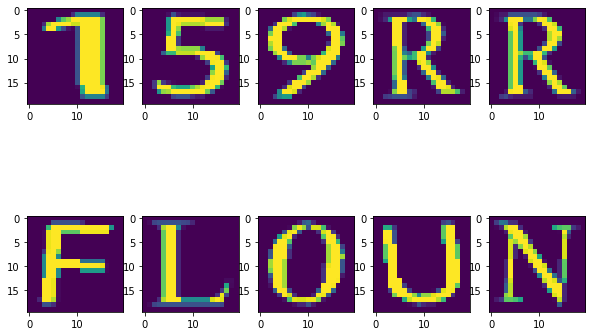

In [7]:
# Visualizing Training data
fig = plt.figure(figsize=(10, 7))

for i in range(10):
  fig.add_subplot(2, 5, i+1)
  print(data[i][1])
  imshow(data[i][0])
plt.show()

In [8]:
# Making the model and training it
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=image_size),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(36)
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.fit(
    np.array(train_images), 
    np.array(train_labels), 
    epochs=10,
    batch_size=100
)

Epoch 1/10
288/288 [==============================] - 3s 8ms/step - loss: 0.5020 - accuracy: 0.8860
Epoch 2/10
288/288 [==============================] - 2s 8ms/step - loss: 0.0043 - accuracy: 0.9990
Epoch 3/10
288/288 [==============================] - 2s 8ms/step - loss: 0.0054 - accuracy: 0.9983
Epoch 4/10
288/288 [==============================] - 2s 9ms/step - loss: 0.0218 - accuracy: 0.9949
Epoch 5/10
288/288 [==============================] - 2s 8ms/step - loss: 1.5444e-05 - accuracy: 1.0000
Epoch 6/10
288/288 [==============================] - 2s 8ms/step - loss: 3.2826e-06 - accuracy: 1.0000
Epoch 7/10
288/288 [==============================] - 2s 8ms/step - loss: 1.2617e-06 - accuracy: 1.0000
Epoch 8/10
288/288 [==============================] - 2s 8ms/step - loss: 6.4742e-07 - accuracy: 1.0000
Epoch 9/10
288/288 [==============================] - 2s 8ms/step - loss: 3.7865e-07 - accuracy: 1.0000
Epoch 10/10
288/288 [==============================] - 2s 8ms/step - loss: 2.157

In [9]:
system("mkdir -p models")
# model.save('./models/my_model_84.h5')

# Predicting on test images
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(np.array(test_images))

p=0
for i in range(len(test_images)):
  if np.argmax(predictions[i]) == test_labels[i]:
    p+=1

print("Test accuracy: ", 100*p/len(test_images))

Test accuracy:  100.0


In [11]:
fil_dir = "./dataset-simple-uppercase/data/"
total = 0
char_p = 0
char_n = 0
cap_p = 0
cap_n = 0

for fil in listdir(fil_dir):
  image = cv2.imread(fil_dir + fil)
  # imshow(image), plt.show()
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

  cnts, new = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
  captcha = np.invert(thresh)
  labelled_captcha = measure.label(captcha)

  character_dimensions = (
      0.25*captcha.shape[0], 
      0.95*captcha.shape[0], 
      0.05*captcha.shape[1], 
      0.3*captcha.shape[1]
  )
  min_height, max_height, min_width, max_width = character_dimensions

  characters = []
  charactersx = []
  counter=0
  column_list = []
  row_list = []
  d = []
  for regions in regionprops(labelled_captcha):
      y0, x0, y1, x1 = regions.bbox
      region_height = y1 - y0
      region_width = x1 - x0

      if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
          roi = captcha[y0:y1, x0:x1]
          resized_char = cv2.copyMakeBorder(roi, 10, 10, 10, 10, cv2.BORDER_CONSTANT)
          resized_char = resize(roi, image_size)
          column_list.append(x0)
          d.append([x0, resized_char])
  d = sorted(d)
  predicted_captcha = ""  
  ind=0
  for _,each_character in d:
      x_p,y_p = 3,3
      each_character = cv2.copyMakeBorder(each_character, x_p, x_p, y_p, y_p, cv2.BORDER_CONSTANT)
      each_character = cv2.resize(each_character,image_size)
      
      # imshow(each_character), plt.show()
      each_character = each_character.reshape(1, -1)
    
      result, = probability_model.predict([each_character])
      r = np.argmax(result)
      
      if r<10:
        # print(chr(48+r))
        predicted_captcha+=chr(48+r)
        if fil[ind] == chr(48+r):char_p += 1
        else:char_n += 1
      else:
        # print(chr(55+r))
        predicted_captcha+=chr(65-10+r)
        if fil[ind] == chr(65-10+r):char_p += 1
        else:char_n += 1
      ind += 1
  
  if predicted_captcha == fil[:6]: cap_p+=1
  else:cap_n+=1

  # Statistics
  stats = pd.DataFrame(
    [
        [char_p, char_n, 100*char_p/(char_p+char_n)], 
        [cap_p, cap_n, 100*cap_p/(cap_p+cap_n)]
    ], 
    index=["Char", "Captcha"],
    columns=["Pos", "Neg", "Acc"]
  )
  total+=1
  clear_output(wait=True)
  display(HTML(stats.to_html()))
  print("Current file: ", total)
  print(fil[:6], ":", predicted_captcha)

,Pos,Neg,Acc
Char,49044,7860,86.187263
Captcha,6554,3446,65.540000


Current file:  10000
FXYQIR : FXYQR
